In [43]:
%matplotlib notebook

In [44]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [45]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [46]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [41]:
MALES = [11, 17, 20, 24, 26, 28, 30, 33, 34]
FEMALES = [10, 14, 21, 22, 23, 25, 27, 29, 31, 32]

## Entreno el modelo que vamos a usar para predecir

In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [8]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

### Levanto el chekpoint en pandas

In [9]:
birds_data_complete = pd.read_parquet('tmp/checkpoint-cog.parquet')
birds_data = birds_data_complete.drop(columns=['tag_id','timestamp'])

### Obtengo las predicciones

In [30]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(birds_data_complete)], axis=1).values

### Calculo si la prediccion cayó dentro de la grilla

In [31]:
def set_prediction_grid_classification(predictions):
    grid_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])
        if GRID.contains(point):
            grid_pred = np.insert(prediction, 8,'in_grid', axis=0)
        else:
            grid_pred = np.insert(prediction, 8,'out_grid', axis=0)
        grid_predictions.append(grid_pred)
    return pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


### Obtengo el tiempo en que cada posible pareja esta junta

In [32]:
def get_bird_timestamp_in_grid(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in bird_data['time']:
        real_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append(datetime.strftime(res, '%Y-%m-%d %H:%M:%S'))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['time'])


def get_grid_matches_per_bird(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions['region'] == 'in_grid')]

    matches_per_bird = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions['region'] == 'in_grid')]
        timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index('time'), on='time', how='inner')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, 0)
            female_matches[tag] = current_matches+1

        matches_per_bird[female_bird] = female_matches
    return matches_per_bird



### Imprimo matriz de confusion

In [33]:
def show_confusion_matrices(matches_per_female):
    matrix_res = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        for m in MALES:
            matrix_res[i].append(matches_per_female.get(FEMALES[i]).get(m, 0))
         
    plt.figure(figsize=(10,15))
    
    plt.subplot(3, 1, 1)
    plt.title('Birds matches')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    yield matrix_res_pd
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
    ax.set(xlabel='Males', ylabel='Females')



    ### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
    ### con cualquier hembra estuvieron juntos
    plt.subplot(3, 1, 2)
    plt.title('Male time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')


    ### Igual, pero con las hembras
    plt.subplot(3, 1, 3)
    plt.title('Female time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')



In [34]:
def evaluate_grid_coocurrence(predictions, delta_time=5):
    predictions = set_prediction_grid_classification(predictions)
    matches_per_bird = get_grid_matches_per_bird(predictions, delta_time)
    show_confusion_matrices(matches_per_bird)

## Analizo coocurrencia en regiones uniformes

### Calculo en que region cayo la prediccion

In [35]:
X_REGION_SIZE = 300
Y_REGION_SIZE = 300


def set_prediction_in_regions_classification(predictions):
    grid_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])

        region = '{}-{}'.format(int(prediction[0]/X_REGION_SIZE), int(prediction[1]/Y_REGION_SIZE))

        grid_pred = np.insert(prediction, 8,region, axis=0)
        grid_predictions.append(grid_pred)
    return pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


### Obtengo el tiempo que cada posible pareja estuvo junta

In [36]:
def get_bird_timestamp_in_regions(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in zip(bird_data.time, bird_data.region):
        real_time = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append((row[1], datetime.strftime(res, '%Y-%m-%d %H:%M:%S')))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['region','time'])


def get_matches_per_bird_in_regions(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions.region.notnull())]

    matches_per_bird_near_antenna = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions.region.notnull())]
        timestamp_in_grid_pd = get_bird_timestamp_in_regions(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index(['region','time']), on=['region','time'], how='inner')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, 0)
            female_matches[tag] = current_matches+1

        matches_per_bird_near_antenna[female_bird] = female_matches
    return matches_per_bird_near_antenna



In [37]:
delta_time=5
predictions = set_prediction_in_regions_classification(predictions)
matches_per_bird = get_matches_per_bird_in_regions(predictions, delta_time)


In [38]:
show_confusion_matrices(matches_per_bird)

<generator object show_confusion_matrices at 0x12d69b580>

In [39]:
matches_per_female = matches_per_bird

<IPython.core.display.Javascript object>


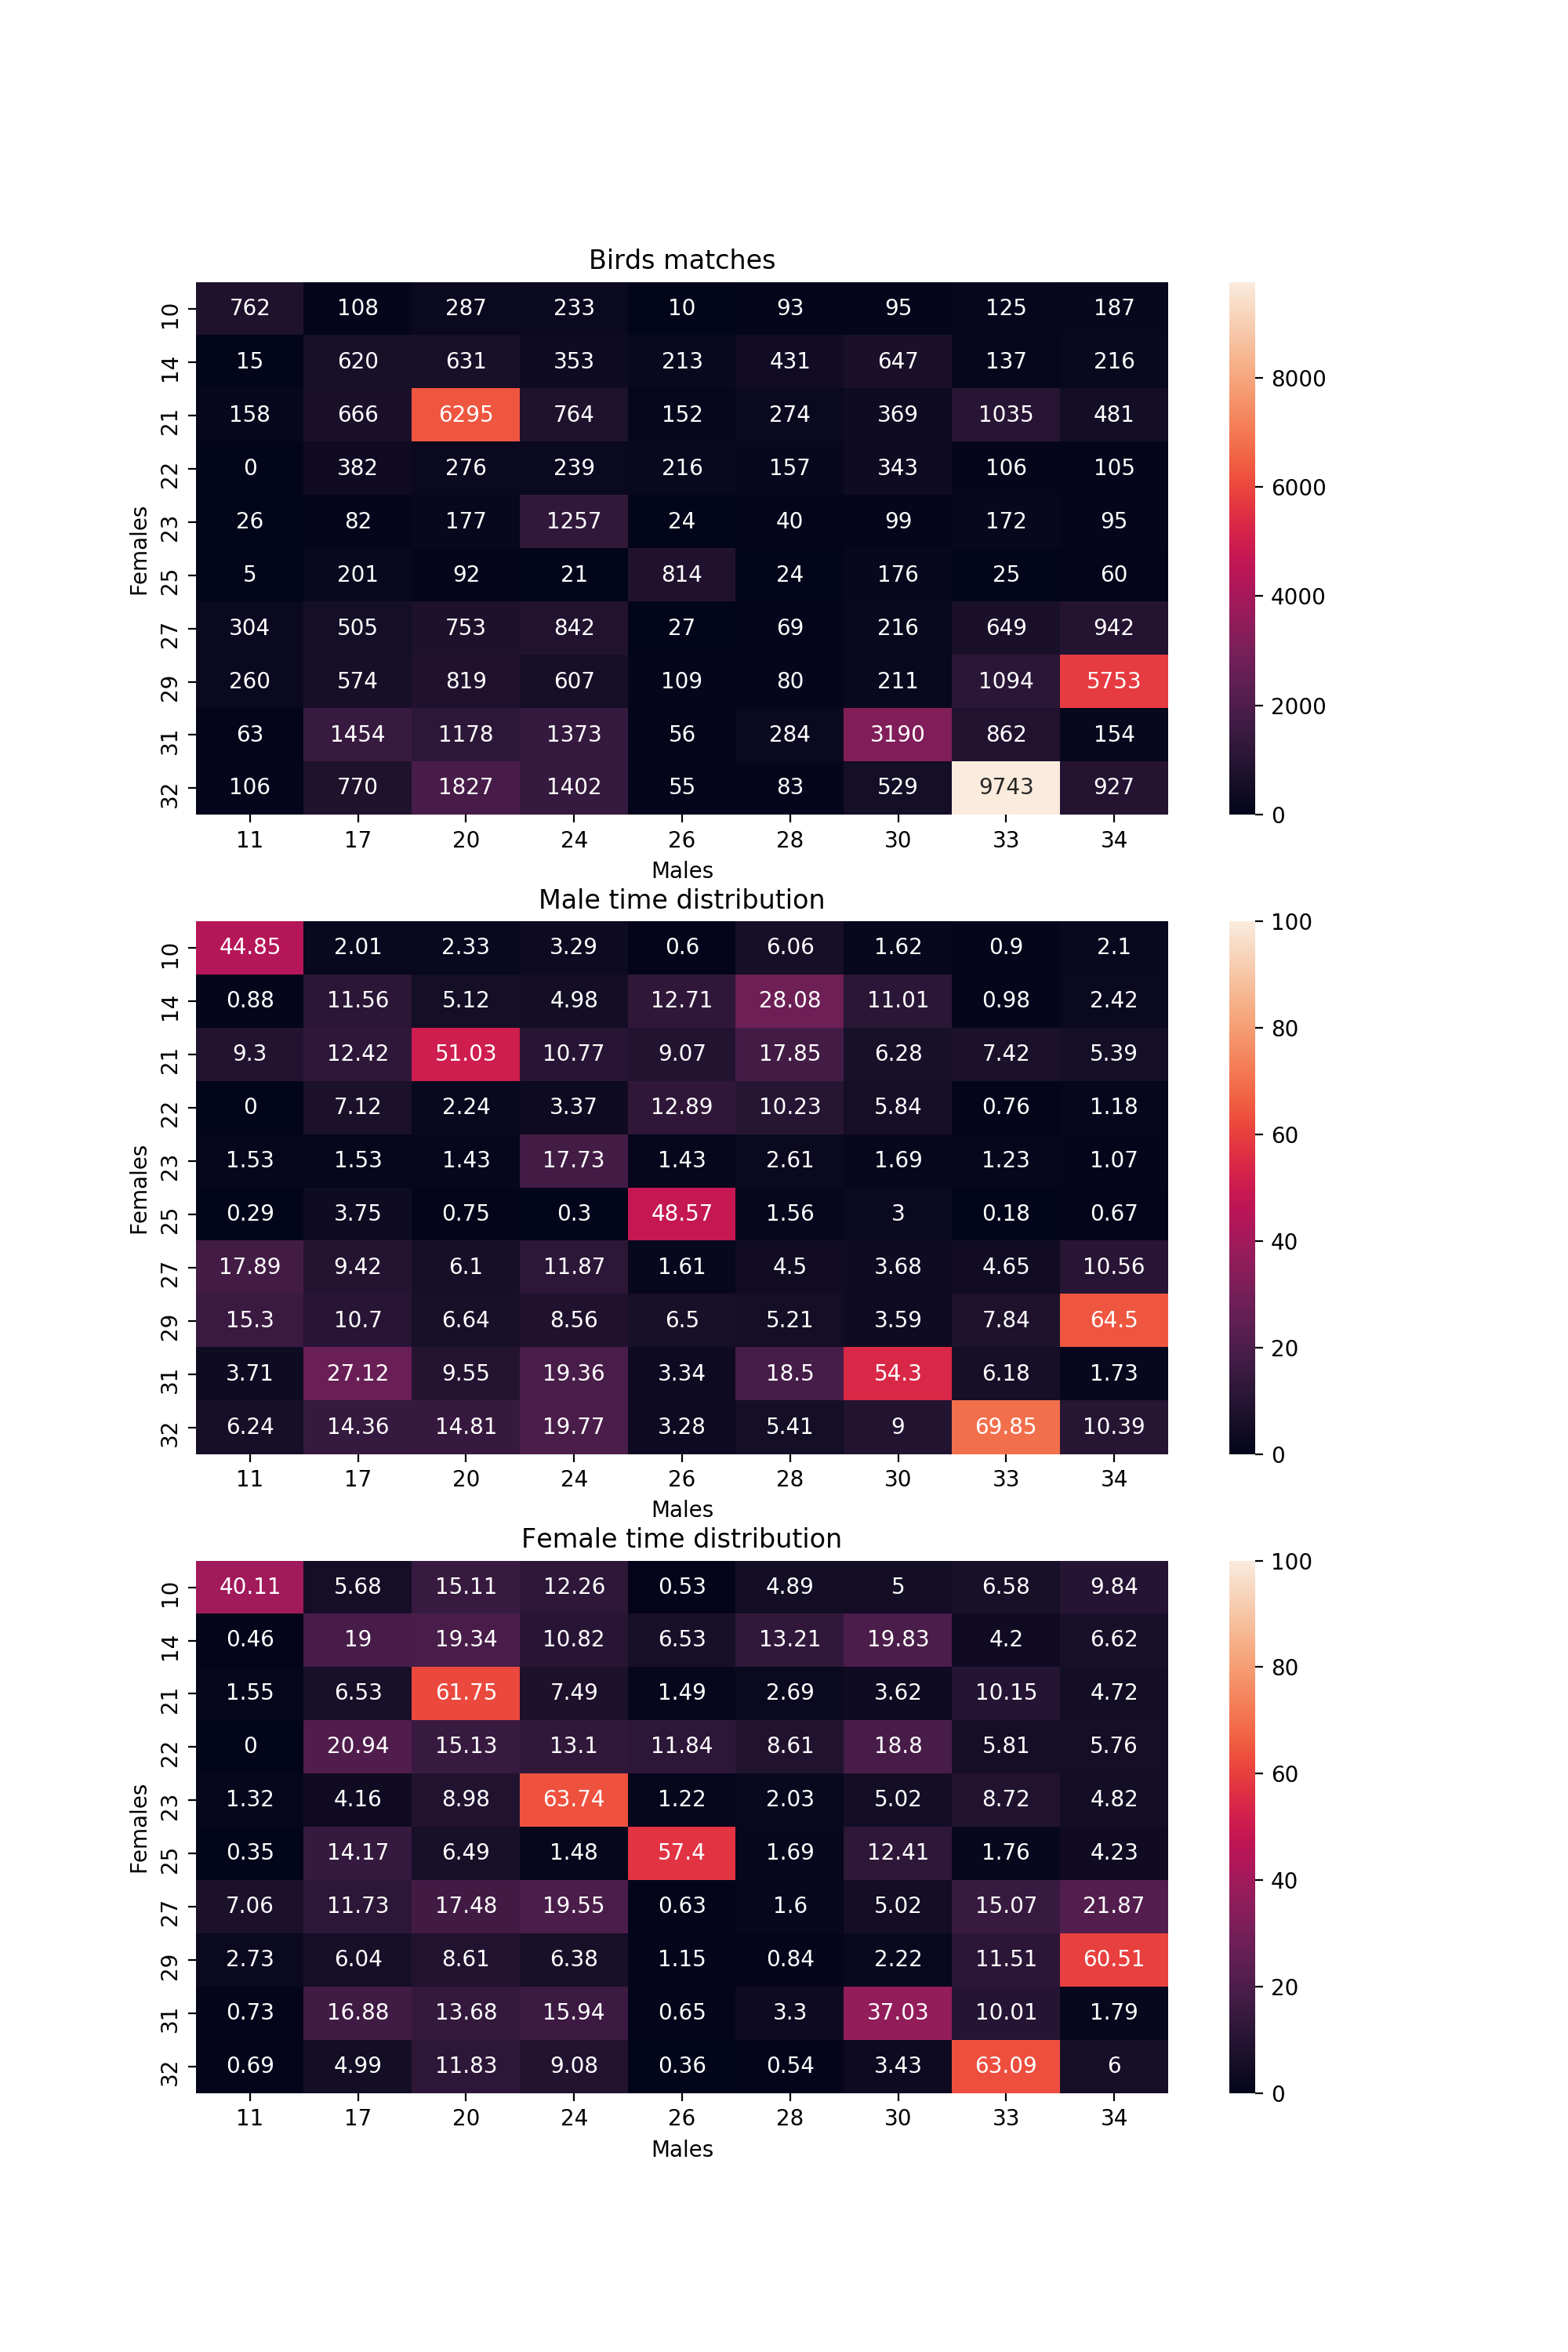

[Text(95.72222222222221, 0.5, 'Females'),
 Text(0.5, 135.7222222222222, 'Males')]

In [42]:
matrix_res = [[]] * len(FEMALES)
for i in range(len(FEMALES)):
    matrix_res[i] = []
    for m in MALES:
        matrix_res[i].append(matches_per_female.get(FEMALES[i]).get(m, 0))

plt.figure(figsize=(10,15))

plt.subplot(3, 1, 1)
plt.title('Birds matches')
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)

ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
ax.set(xlabel='Males', ylabel='Females')



### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
### con cualquier hembra estuvieron juntos
plt.subplot(3, 1, 2)
plt.title('Male time distribution')
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
matrix_res_pd = matrix_res_pd.fillna(0)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
ax.set(xlabel='Males', ylabel='Females')


### Igual, pero con las hembras
plt.subplot(3, 1, 3)
plt.title('Female time distribution')
matrix_res_pd = pd.DataFrame(matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
matrix_res_pd = matrix_res_pd.fillna(0)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
ax.set(xlabel='Males', ylabel='Females')